N2550 - Fundementals of Image Processing and Machine Vision

Name : R.G.S.M. RANATUNGA

Index No. : 190504H

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

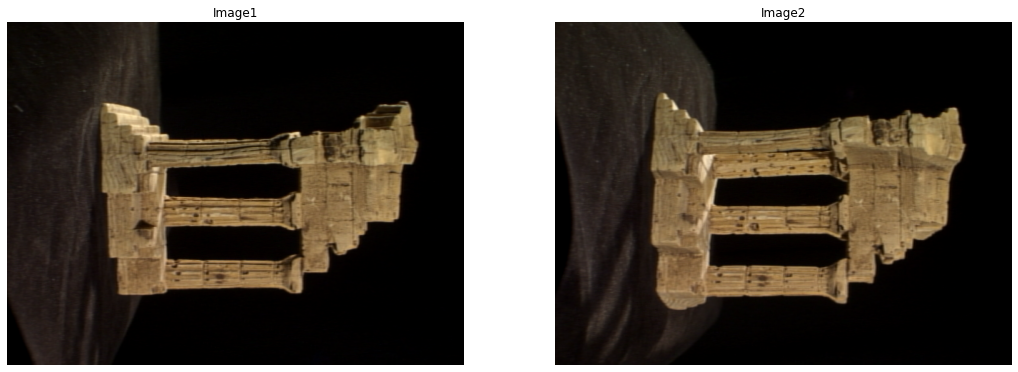

In [2]:
f = open(r'./templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())

# Reading the information on the first image
l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image
l = f.readline().split()
im2_fn = l[0]

K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Read the two images and show
im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None 
assert im2 is not None 

fig,ax = plt.subplots(1,2,figsize = (18, 18))

ax[0].set_title('Image1')
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].set_title('Image2')
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].axis('off')

# Compute P1 and P2
P1 = K1 @ np.hstack((R1, t1)) #P =K*[R|t]
P2 = K2 @ np.hstack((R2, t2))


In [3]:
from scipy.linalg import null_space
def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

C = null_space(P1)
C = C* np.sign(C[0,0])
e2 = P2 @ C

e2x = skew(e2)

F = e2x @ P2 @np.linalg.pinv(P1)
F

array([[-2.87071497e-04, -3.96261289e-02,  2.94221686e+02],
       [-3.55039713e-02,  1.65329260e-04,  1.78860854e+01],
       [-2.76702814e+02,  2.12942175e+01, -9.06669374e+03]])

(-0.5, 639.5, 479.5, -0.5)

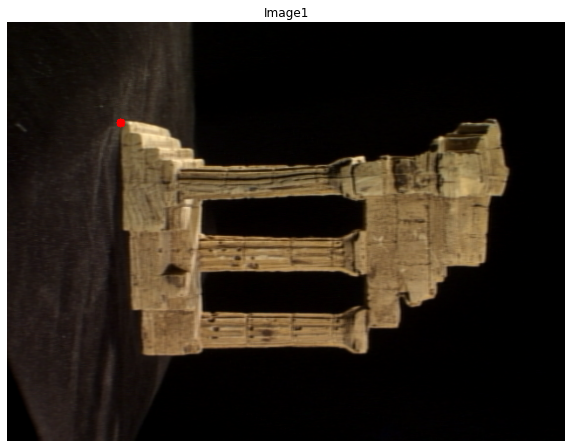

In [4]:
x = np.array([130, 115, 1])
cv.circle(im1, (x[0], x[1]), 5, (0, 0, 255), -1)

fig,ax = plt.subplots(figsize = (10, 10))
ax.set_title('Image1')
ax.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax.axis('off')

(-0.5, 639.5, 479.5, -0.5)

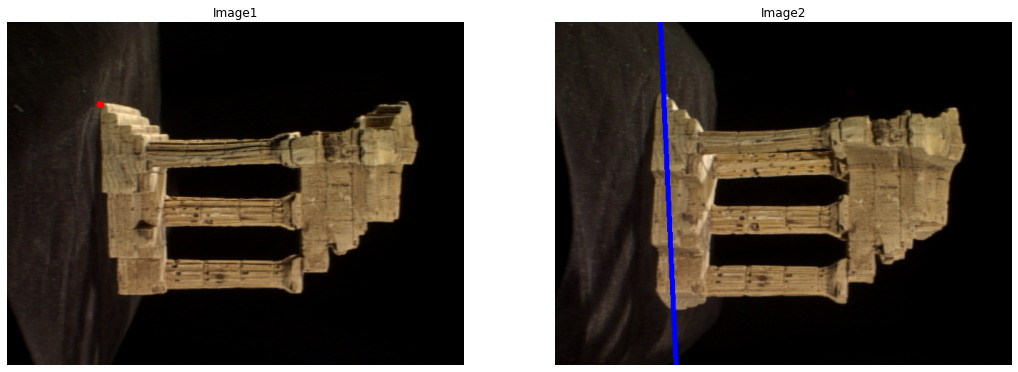

In [5]:
l2 = F @ x.T
p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500, (l2[0]*500 + l2[2])/l2[1]]).astype(int)

cv.line(im2, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 0), 5)

fig,ax = plt.subplots(1,2,figsize = (18, 18))
ax[0].set_title('Image1')
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].axis('off')

ax[1].set_title('Image2')
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].axis('off')

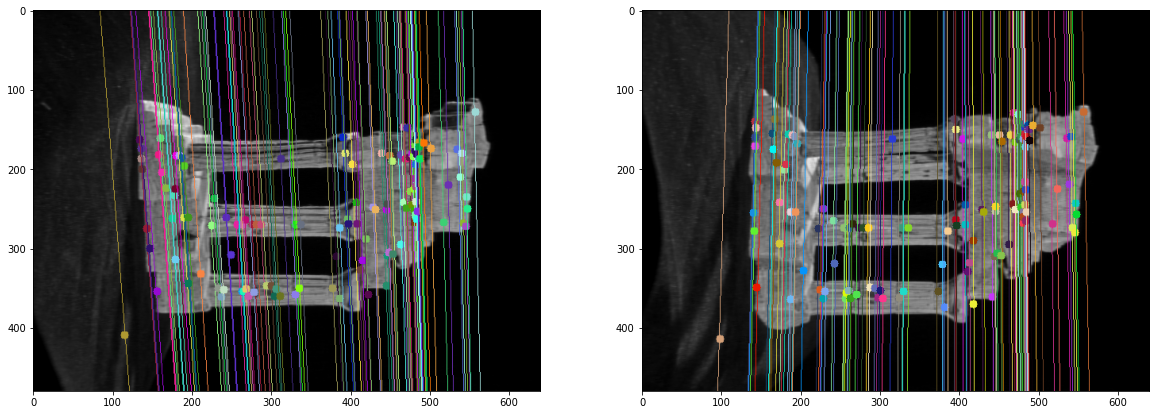

In [10]:
im1 = cv.imread(r'./templeSparseRing/'+im1_fn,0)
im2 = cv.imread(r'./templeSparseRing/'+im2_fn,0) 
sift = cv.SIFT_create()

keypoint1, descriptor1 = sift.detectAndCompute(im1,None)
keypoint2, descriptor2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
ind_para = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_para = dict(checks=50)
flann = cv.FlannBasedMatcher(ind_para,search_para)
matches = flann.knnMatch(descriptor1,descriptor2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(keypoint2[m.trainIdx].pt)
        pts1.append(keypoint1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(im1,im2,lines,pts1,pts2):
    r,c = im1.shape
    im1 = cv.cvtColor(im1,cv.COLOR_GRAY2BGR)
    im2 = cv.cvtColor(im2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        im1 = cv.line(im1, (x0,y0), (x1,y1), color,1)
        im1 = cv.circle(im1,tuple(pt1),5,color,-1)
        im2 = cv.circle(im2,tuple(pt2),5,color,-1)
    return im1,im2

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(im1,im2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(im2,im1,lines2,pts2,pts1)

plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()